# Cálculo de coeficiente min-max para polinomio

## Cálculo para Ln

In [24]:
import numpy as np
import mpmath

def transpose_mpmath_matrix(matrix):
    rows = matrix.rows
    cols = matrix.cols
    transposed = mpmath.matrix(cols, rows)  # Create a new matrix with swapped dimensions
    for i in range(rows):
        for j in range(cols):
            transposed[j, i] = matrix[i, j]
    return transposed

# 1. Definir a precisão desejada para os cálculos com mpmath
# (dps = decimal places of precision; mpmath recomenda dps > precisão final desejada)
# Para 28 dígitos finais, usar pelo menos dps=40 ou 50.
mpmath.mp.dps = 50 # Aumente se necessário para ter mais margem

# 2. Definir o intervalo de aproximação para o polinômio.
# A função C# usa ln(s) = -ln(1/s) onde s está em [1, 2).
# Então, 1/s (vamos chamar de x_poly) está em (0.5, 1].
# É melhor aproximar ln(x_poly) neste intervalo (0.5, 1].
n_pontos = 10000  # Número de pontos para o ajuste.
                # Para um grau N, você precisa de pelo menos N+1 pontos.
                # Mais pontos podem levar a um melhor ajuste de mínimos quadrados.
x_poly_mp = mpmath.linspace(mpmath.mpf('0.5'), mpmath.mpf('1.0'), n_pontos)

# 3. Calcular os valores de y = ln(x_poly) usando mpmath
y_target_mp = [mpmath.log(x) for x in x_poly_mp]

# 4. Grau do polinômio
grau = 20 # Comece com um grau como 15-20. Ajuste conforme necessário.
          # Um grau muito alto pode levar a instabilidade numérica.

print(f"Tentando ajustar um polinômio de grau {grau} com {n_pontos} pontos usando mpmath...")
print(f"Precisão de trabalho (mpmath.mp.dps): {mpmath.mp.dps}")

try:
    # Implementação de mínimos quadrados com mpmath
    # Queremos encontrar coeficientes c_0, c_1, ..., c_grau tal que
    # P(x) = c_0 * x^grau + c_1 * x^(grau-1) + ... + c_grau aproxime y_target_mp.
    # Isso é resolver o sistema linear V * c = Y no sentido de mínimos quadrados.
    # A solução é c = (V^T V)^(-1) V^T Y.

    # Construir a matriz de Vandermonde V com mpmath
    # V[i, j] = x_poly_mp[i] ^ (grau - j)
    V_mp = mpmath.matrix(n_pontos, grau + 1)
    for i in range(n_pontos):
        for j in range(grau + 1):
            # O polinômio é c[0]*x^grau + c[1]*x^(grau-1) + ... + c[grau]
            V_mp[i, j] = mpmath.power(x_poly_mp[i], grau - j)

    # Converter y_target_mp para uma matriz coluna mpmath
    Y_mp_col = mpmath.matrix(y_target_mp)

    # Calcular V^T
    V_T_mp = transpose_mpmath_matrix(V_mp)

    # Calcular (V^T V)
    V_T_V_mp = V_T_mp * V_mp

    # Calcular (V^T Y)
    V_T_Y_mp = V_T_mp * Y_mp_col
    
    # Resolver o sistema (V^T V) * coef = (V^T Y) para coef
    coeficientes_mpmath_lst = mpmath.lu_solve(V_T_V_mp, V_T_Y_mp)

    # coeficientes_mpmath_lst é uma matriz coluna, converter para lista de strings
    # Usar mpmath.nstr para formatar com alta precisão, evitando notação científica se possível
    # para facilitar a cópia para C#. O número de dígitos em nstr deve ser alto.
    coeficientes_mpmath_str = [mpmath.nstr(c, mpmath.mp.dps - 5, min_fixed=-100, max_fixed=100) for c in coeficientes_mpmath_lst]

    print("\nCoeficientes calculados com mpmath (alta precisão):")
    print(f"// Grau do polinômio: {grau}")
    print(f"// Intervalo de aproximação para x_poly: (0.5, 1.0]")
    print(f"// Função aproximada: ln(x_poly)")
    print(f"// Precisão de trabalho mpmath (dps): {mpmath.mp.dps}")
    print(f"// Número de pontos de ajuste: {n_pontos}")
    print("private static readonly decimal[] LnCoefficients = new decimal[]")
    print("{")
    for i, c_str in enumerate(coeficientes_mpmath_str):
        formatted_c_str = c_str.strip()
        print(f"    {formatted_c_str}m{(',' if i < len(coeficientes_mpmath_str) - 1 else '')}")
    print("};")

    # Verificação opcional do erro máximo nos pontos de ajuste
    max_abs_error_check = mpmath.mpf(0)
    for i in range(n_pontos):
       x_val = x_poly_mp[i]
       y_actual_val = y_target_mp[i]
       poly_eval = mpmath.mpf(0)
       # Avaliar P(x) = c_0 * x^grau + c_1 * x^(grau-1) + ... + c_grau
       for j in range(grau + 1):
           poly_eval += coeficientes_mpmath_lst[j] * mpmath.power(x_val, grau - j)
       abs_error = mpmath.fabs(y_actual_val - poly_eval)
       if abs_error > max_abs_error_check:
           max_abs_error_check = abs_error
    print(f"\n// Verificação: Máximo erro absoluto da aproximação mpmath nos pontos de ajuste: {mpmath.nstr(max_abs_error_check, 10)}")
    # Um erro esperado para 28 dígitos de precisão seria algo na ordem de 10^-29 ou menor.
    # O erro nos pontos de ajuste não garante o erro máximo em todo o intervalo.
    if max_abs_error_check > mpmath.power(10, -30): # Ajuste este limiar conforme necessário
        print("// AVISO: O erro máximo nos pontos de ajuste pode ser maior do que o ideal para 28-29 dígitos de precisão.")

except Exception as e:
    print(f"\nErro ao calcular coeficientes com mpmath: {e}")
    print("Isso pode ocorrer se a matriz (V^T V) for mal condicionada ou singular.")
    print("Tente as seguintes sugestões:")
    print("  - Reduzir o 'grau' do polinômio (valores altos são propensos à instabilidade).")
    print("  - Aumentar 'n_pontos' (por exemplo, 2 * grau ou mais, até algumas centenas).")
    print("  - Aumentar 'mpmath.mp.dps' ainda mais (ex: 60 ou 70), pois os cálculos de V^T V podem perder precisão.")
    print("  - Certifique-se de que o intervalo de 'x_poly_mp' é razoável e não inclui pontos problemáticos.")

print("\n--- Notas Importantes ---")
print("1. Precisão dos Coeficientes: Os coeficientes gerados com `mpmath` devem ter alta precisão.")
print("   Copie-os para sua classe `DecimalMath` em C#.")
print("2. Teste Rigoroso em C#: Após atualizar os coeficientes, teste exaustivamente a função `Ln`")
print("   em C# contra valores de referência de alta precisão (ex: `mpmath.log` com `dps` alto).")
print("   A tolerância nos seus testes unitários C# (`DecimalMathTests.cs`) deve ser muito pequena (ex: 1e-28m).")
print("3. Estabilidade: Se encontrar problemas de instabilidade (erros grandes, falha na solução),")
print("   a principal estratégia é reduzir o grau do polinômio. Um polinômio de grau menor com")
print("   coeficientes muito precisos geralmente é melhor e mais estável.")
print("4. Convergência: Verifique o `Máximo erro absoluto` impresso. Se for muito maior que ~10^-29,")
print("   a aproximação pode não ser boa o suficiente para 28 dígitos em todo o intervalo.")

Tentando ajustar um polinômio de grau 20 com 10000 pontos usando mpmath...
Precisão de trabalho (mpmath.mp.dps): 50

Coeficientes calculados com mpmath (alta precisão):
// Grau do polinômio: 20
// Intervalo de aproximação para x_poly: (0.5, 1.0]
// Função aproximada: ln(x_poly)
// Precisão de trabalho mpmath (dps): 50
// Número de pontos de ajuste: 10000
private static readonly decimal[] LnCoefficients = new decimal[]
{
    -27.7820315854339204174599445676875473991892085m,
    438.037437366718703774562014492789921512128798m,
    -3280.75439930850425698092423501934067990851792m,
    15524.3648482283015457635106218447102907364758m,
    -52070.934850915329908194394680547654381561877m,
    131651.968437459610951150883745402991648461708m,
    -260474.43167012822998215660328552413547815159m,
    413225.898599094091121720442678920621461457563m,
    -534289.253998163616138914010930167868054495957m,
    569161.782147278003599907874578033523511870939m,
    -502927.0480371109428679526700695931187

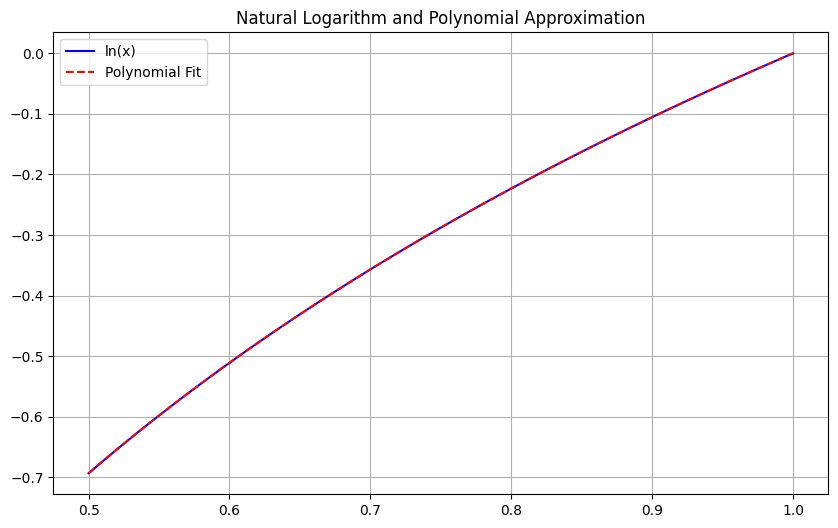

In [25]:
import matplotlib.pyplot as plt
y_fit = np.polyval(coeficientes_mpmath_lst, x_poly_mp)
plt.figure(figsize=(10, 6))
plt.plot(x_poly_mp, y_target_mp, 'b-', label='ln(x)')
plt.plot(x_poly_mp, y_fit, 'r--', label='Polynomial Fit')
plt.legend()
plt.grid(True)
plt.title('Natural Logarithm and Polynomial Approximation')
plt.show()

## Cálculo para Exp

In [26]:
# 1. Definir a precisão desejada para os cálculos com mpmath
# (dps = decimal places of precision; mpmath recomenda dps > precisão final desejada)
# Para 28 dígitos finais, usar pelo menos dps=40 ou 50.
mpmath.mp.dps = 50 # Aumente se necessário para ter mais margem

# 2. Definir o intervalo de aproximação para o polinômio.
# A função C# usa ln(s) = -ln(1/s) onde s está em [1, 2).
# Então, 1/s (vamos chamar de x_poly) está em (0.5, 1].
# É melhor aproximar ln(x_poly) neste intervalo (0.5, 1].
n_pontos = 10000  # Número de pontos para o ajuste.
                # Para um grau N, você precisa de pelo menos N+1 pontos.
                # Mais pontos podem levar a um melhor ajuste de mínimos quadrados.

# Constante LN2 com alta precisão usando mpmath
LN2_mp = mpmath.log(2) # mpmath.log é o logaritmo natural

# Intervalo para r (o argumento do polinômio para exp(r))
# r está em [-LN2/2, LN2/2]
r_min_mp = -LN2_mp / 2
r_max_mp = LN2_mp / 2

x_poly_mp = mpmath.linspace(r_min_mp, r_max_mp, n_pontos)

# 3. Calcular os valores de y = ln(x_poly) usando mpmath
y_target_mp = [mpmath.exp(x) for x in x_poly_mp]

# 4. Grau do polinômio
grau = 18 # Comece com um grau como 15-20. Ajuste conforme necessário.
          # Um grau muito alto pode levar a instabilidade numérica.

print(f"Tentando ajustar um polinômio de grau {grau} com {n_pontos} pontos usando mpmath...")
print(f"Precisão de trabalho (mpmath.mp.dps): {mpmath.mp.dps}")

try:
    # Implementação de mínimos quadrados com mpmath
    # Queremos encontrar coeficientes c_0, c_1, ..., c_grau tal que
    # P(x) = c_0 * x^grau + c_1 * x^(grau-1) + ... + c_grau aproxime y_target_mp.
    # Isso é resolver o sistema linear V * c = Y no sentido de mínimos quadrados.
    # A solução é c = (V^T V)^(-1) V^T Y.

    # Construir a matriz de Vandermonde V com mpmath
    # V[i, j] = x_poly_mp[i] ^ (grau - j)
    V_mp = mpmath.matrix(n_pontos, grau + 1)
    for i in range(n_pontos):
        for j in range(grau + 1):
            # O polinômio é c[0]*x^grau + c[1]*x^(grau-1) + ... + c[grau]
            V_mp[i, j] = mpmath.power(x_poly_mp[i], grau - j)

    # Converter y_target_mp para uma matriz coluna mpmath
    Y_mp_col = mpmath.matrix(y_target_mp)

    # Calcular V^T
    V_T_mp = transpose_mpmath_matrix(V_mp)

    # Calcular (V^T V)
    V_T_V_mp = V_T_mp * V_mp

    # Calcular (V^T Y)
    V_T_Y_mp = V_T_mp * Y_mp_col
    
    # Resolver o sistema (V^T V) * coef = (V^T Y) para coef
    coeficientes_mpmath_lst = mpmath.lu_solve(V_T_V_mp, V_T_Y_mp)

    # coeficientes_mpmath_lst é uma matriz coluna, converter para lista de strings
    # Usar mpmath.nstr para formatar com alta precisão, evitando notação científica se possível
    # para facilitar a cópia para C#. O número de dígitos em nstr deve ser alto.
    coeficientes_mpmath_str = [mpmath.nstr(c, mpmath.mp.dps - 5, min_fixed=-100, max_fixed=100) for c in coeficientes_mpmath_lst]

    print("\nCoeficientes calculados com mpmath (alta precisão):")
    print(f"// Grau do polinômio: {grau}")
    print(f"// Intervalo de aproximação para x_poly: ({r_min_mp}, {r_max_mp}]")
    print(f"// Função aproximada: exp(x_poly)")
    print(f"// Precisão de trabalho mpmath (dps): {mpmath.mp.dps}")
    print(f"// Número de pontos de ajuste: {n_pontos}")
    print("private static readonly decimal[] ExpCoefficients = new decimal[]")
    print("{")
    for i, c_str in enumerate(coeficientes_mpmath_str):
        formatted_c_str = c_str.strip()
        print(f"    {formatted_c_str}m{(',' if i < len(coeficientes_mpmath_str) - 1 else '')}")
    print("};")

    # Verificação opcional do erro máximo nos pontos de ajuste
    max_abs_error_check = mpmath.mpf(0)
    for i in range(n_pontos):
       x_val = x_poly_mp[i]
       y_actual_val = y_target_mp[i]
       poly_eval = mpmath.mpf(0)
       # Avaliar P(x) = c_0 * x^grau + c_1 * x^(grau-1) + ... + c_grau
       for j in range(grau + 1):
           poly_eval += coeficientes_mpmath_lst[j] * mpmath.power(x_val, grau - j)
       abs_error = mpmath.fabs(y_actual_val - poly_eval)
       if abs_error > max_abs_error_check:
           max_abs_error_check = abs_error
    print(f"\n// Verificação: Máximo erro absoluto da aproximação mpmath nos pontos de ajuste: {mpmath.nstr(max_abs_error_check, 10)}")
    # Um erro esperado para 28 dígitos de precisão seria algo na ordem de 10^-29 ou menor.
    # O erro nos pontos de ajuste não garante o erro máximo em todo o intervalo.
    if max_abs_error_check > mpmath.power(10, -30): # Ajuste este limiar conforme necessário
        print("// AVISO: O erro máximo nos pontos de ajuste pode ser maior do que o ideal para 28-29 dígitos de precisão.")

except Exception as e:
    print(f"\nErro ao calcular coeficientes com mpmath: {e}")
    print("Isso pode ocorrer se a matriz (V^T V) for mal condicionada ou singular.")
    print("Tente as seguintes sugestões:")
    print("  - Reduzir o 'grau' do polinômio (valores altos são propensos à instabilidade).")
    print("  - Aumentar 'n_pontos' (por exemplo, 2 * grau ou mais, até algumas centenas).")
    print("  - Aumentar 'mpmath.mp.dps' ainda mais (ex: 60 ou 70), pois os cálculos de V^T V podem perder precisão.")
    print("  - Certifique-se de que o intervalo de 'x_poly_mp' é razoável e não inclui pontos problemáticos.")

print("\n--- Notas Importantes ---")
print("1. Precisão dos Coeficientes: Os coeficientes gerados com `mpmath` devem ter alta precisão.")
print("   Copie-os para sua classe `DecimalMath` em C#.")
print("2. Teste Rigoroso em C#: Após atualizar os coeficientes, teste exaustivamente a função `Ln`")
print("   em C# contra valores de referência de alta precisão (ex: `mpmath.log` com `dps` alto).")
print("   A tolerância nos seus testes unitários C# (`DecimalMathTests.cs`) deve ser muito pequena (ex: 1e-28m).")
print("3. Estabilidade: Se encontrar problemas de instabilidade (erros grandes, falha na solução),")
print("   a principal estratégia é reduzir o grau do polinômio. Um polinômio de grau menor com")
print("   coeficientes muito precisos geralmente é melhor e mais estável.")
print("4. Convergência: Verifique o `Máximo erro absoluto` impresso. Se for muito maior que ~10^-29,")
print("   a aproximação pode não ser boa o suficiente para 28 dígitos em todo o intervalo.")

Tentando ajustar um polinômio de grau 18 com 10000 pontos usando mpmath...
Precisão de trabalho (mpmath.mp.dps): 50

Coeficientes calculados com mpmath (alta precisão):
// Grau do polinômio: 18
// Intervalo de aproximação para x_poly: (-0.34657359027997265470861606072908828403775006718013, 0.34657359027997265470861606072908828403775006718013]
// Função aproximada: exp(x_poly)
// Precisão de trabalho mpmath (dps): 50
// Número de pontos de ajuste: 10000
private static readonly decimal[] ExpCoefficients = new decimal[]
{
    0.00000000000000015643281607979890113134415758309075331910053m,
    0.00000000000000281602510137494514395524411525232147680166594m,
    0.0000000000000477947135098845946714303606890422967563343993m,
    0.000000000000764715306730313419444327644132494358575570434m,
    0.000000000011470745605943162254935065419279522615161163m,
    0.000000000160590438504118912916059511410513087855078934m,
    0.0000000020876756987861295963833926161438809286365235m,
    0.0000000250521

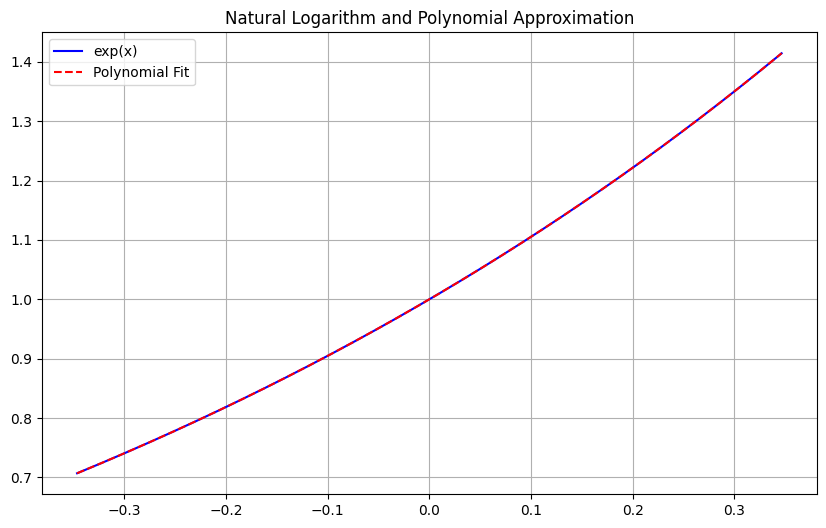

In [27]:
y_fit = np.polyval(coeficientes_mpmath_lst, x_poly_mp)
plt.figure(figsize=(10, 6))
plt.plot(x_poly_mp, y_target_mp, 'b-', label='exp(x)')
plt.plot(x_poly_mp, y_fit, 'r--', label='Polynomial Fit')
plt.legend()
plt.grid(True)
plt.title('Natural Logarithm and Polynomial Approximation')
plt.show()

In [29]:
# 1. Definir a precisão desejada para os cálculos com mpmath
# (dps = decimal places of precision; mpmath recomenda dps > precisão final desejada)
# Para 28 dígitos finais, usar pelo menos dps=40 ou 50.
mpmath.mp.dps = 50 # Aumente se necessário para ter mais margem

# 2. Definir o intervalo de aproximação para o polinômio.
# A função C# usa ln(s) = -ln(1/s) onde s está em [1, 2).
# Então, 1/s (vamos chamar de x_poly) está em (0.5, 1].
# É melhor aproximar ln(x_poly) neste intervalo (0.5, 1].
n_pontos = 10000  # Número de pontos para o ajuste.
                # Para um grau N, você precisa de pelo menos N+1 pontos.
                # Mais pontos podem levar a um melhor ajuste de mínimos quadrados.

# Constante LN2 com alta precisão usando mpmath

# Intervalo para r (o argumento do polinômio para exp(r))
# r está em [-LN2/2, LN2/2]
r_min_mp = 0
r_max_mp = mpmath.pi / 2  # Aproximando exp(r) para r em [0, pi/2]

x_poly_mp = mpmath.linspace(r_min_mp, r_max_mp, n_pontos)

# 3. Calcular os valores de y = ln(x_poly) usando mpmath
y_target_mp = [mpmath.sin(x) for x in x_poly_mp]

# 4. Grau do polinômio
grau = 20 # Comece com um grau como 15-20. Ajuste conforme necessário.
          # Um grau muito alto pode levar a instabilidade numérica.

print(f"Tentando ajustar um polinômio de grau {grau} com {n_pontos} pontos usando mpmath...")
print(f"Precisão de trabalho (mpmath.mp.dps): {mpmath.mp.dps}")

try:
    # Implementação de mínimos quadrados com mpmath
    # Queremos encontrar coeficientes c_0, c_1, ..., c_grau tal que
    # P(x) = c_0 * x^grau + c_1 * x^(grau-1) + ... + c_grau aproxime y_target_mp.
    # Isso é resolver o sistema linear V * c = Y no sentido de mínimos quadrados.
    # A solução é c = (V^T V)^(-1) V^T Y.

    # Construir a matriz de Vandermonde V com mpmath
    # V[i, j] = x_poly_mp[i] ^ (grau - j)
    V_mp = mpmath.matrix(n_pontos, grau + 1)
    for i in range(n_pontos):
        for j in range(grau + 1):
            # O polinômio é c[0]*x^grau + c[1]*x^(grau-1) + ... + c[grau]
            V_mp[i, j] = mpmath.power(x_poly_mp[i], grau - j)

    # Converter y_target_mp para uma matriz coluna mpmath
    Y_mp_col = mpmath.matrix(y_target_mp)

    # Calcular V^T
    V_T_mp = transpose_mpmath_matrix(V_mp)

    # Calcular (V^T V)
    V_T_V_mp = V_T_mp * V_mp

    # Calcular (V^T Y)
    V_T_Y_mp = V_T_mp * Y_mp_col
    
    # Resolver o sistema (V^T V) * coef = (V^T Y) para coef
    coeficientes_mpmath_lst = mpmath.lu_solve(V_T_V_mp, V_T_Y_mp)

    # coeficientes_mpmath_lst é uma matriz coluna, converter para lista de strings
    # Usar mpmath.nstr para formatar com alta precisão, evitando notação científica se possível
    # para facilitar a cópia para C#. O número de dígitos em nstr deve ser alto.
    coeficientes_mpmath_str = [mpmath.nstr(c, mpmath.mp.dps - 5, min_fixed=-100, max_fixed=100) for c in coeficientes_mpmath_lst]

    print("\nCoeficientes calculados com mpmath (alta precisão):")
    print(f"// Grau do polinômio: {grau}")
    print(f"// Intervalo de aproximação para x_poly: ({r_min_mp}, {r_max_mp}]")
    print(f"// Função aproximada: sin(x_poly)")
    print(f"// Precisão de trabalho mpmath (dps): {mpmath.mp.dps}")
    print(f"// Número de pontos de ajuste: {n_pontos}")
    print("private static readonly decimal[] SinCoefficients = new decimal[]")
    print("{")
    for i, c_str in enumerate(coeficientes_mpmath_str):
        formatted_c_str = c_str.strip()
        print(f"    {formatted_c_str}m{(',' if i < len(coeficientes_mpmath_str) - 1 else '')}")
    print("};")

    # Verificação opcional do erro máximo nos pontos de ajuste
    max_abs_error_check = mpmath.mpf(0)
    for i in range(n_pontos):
       x_val = x_poly_mp[i]
       y_actual_val = y_target_mp[i]
       poly_eval = mpmath.mpf(0)
       # Avaliar P(x) = c_0 * x^grau + c_1 * x^(grau-1) + ... + c_grau
       for j in range(grau + 1):
           poly_eval += coeficientes_mpmath_lst[j] * mpmath.power(x_val, grau - j)
       abs_error = mpmath.fabs(y_actual_val - poly_eval)
       if abs_error > max_abs_error_check:
           max_abs_error_check = abs_error
    print(f"\n// Verificação: Máximo erro absoluto da aproximação mpmath nos pontos de ajuste: {mpmath.nstr(max_abs_error_check, 10)}")
    # Um erro esperado para 28 dígitos de precisão seria algo na ordem de 10^-29 ou menor.
    # O erro nos pontos de ajuste não garante o erro máximo em todo o intervalo.
    if max_abs_error_check > mpmath.power(10, -30): # Ajuste este limiar conforme necessário
        print("// AVISO: O erro máximo nos pontos de ajuste pode ser maior do que o ideal para 28-29 dígitos de precisão.")

except Exception as e:
    print(f"\nErro ao calcular coeficientes com mpmath: {e}")
    print("Isso pode ocorrer se a matriz (V^T V) for mal condicionada ou singular.")
    print("Tente as seguintes sugestões:")
    print("  - Reduzir o 'grau' do polinômio (valores altos são propensos à instabilidade).")
    print("  - Aumentar 'n_pontos' (por exemplo, 2 * grau ou mais, até algumas centenas).")
    print("  - Aumentar 'mpmath.mp.dps' ainda mais (ex: 60 ou 70), pois os cálculos de V^T V podem perder precisão.")
    print("  - Certifique-se de que o intervalo de 'x_poly_mp' é razoável e não inclui pontos problemáticos.")

print("\n--- Notas Importantes ---")
print("1. Precisão dos Coeficientes: Os coeficientes gerados com `mpmath` devem ter alta precisão.")
print("   Copie-os para sua classe `DecimalMath` em C#.")
print("2. Teste Rigoroso em C#: Após atualizar os coeficientes, teste exaustivamente a função `Ln`")
print("   em C# contra valores de referência de alta precisão (ex: `mpmath.log` com `dps` alto).")
print("   A tolerância nos seus testes unitários C# (`DecimalMathTests.cs`) deve ser muito pequena (ex: 1e-28m).")
print("3. Estabilidade: Se encontrar problemas de instabilidade (erros grandes, falha na solução),")
print("   a principal estratégia é reduzir o grau do polinômio. Um polinômio de grau menor com")
print("   coeficientes muito precisos geralmente é melhor e mais estável.")
print("4. Convergência: Verifique o `Máximo erro absoluto` impresso. Se for muito maior que ~10^-29,")
print("   a aproximação pode não ser boa o suficiente para 28 dígitos em todo o intervalo.")

Tentando ajustar um polinômio de grau 20 com 10000 pontos usando mpmath...
Precisão de trabalho (mpmath.mp.dps): 50

Coeficientes calculados com mpmath (alta precisão):
// Grau do polinômio: 20
// Intervalo de aproximação para x_poly: (0, 1.5707963267948966192313216916397514420985846996876]
// Função aproximada: sin(x_poly)
// Precisão de trabalho mpmath (dps): 50
// Número de pontos de ajuste: 10000
private static readonly decimal[] SinCoefficients = new decimal[]
{
    0.000000000000000000288565372967092080154910283554541578014434566m,
    -0.0000000000000000103020613832564404063466084302914382514783212m,
    0.00000000000000000947136763506471723503643888938116479276465938m,
    0.00000000000000278134468141772025648080944177219239433082883m,
    0.0000000000000000706106557676478754247100952007639228335174385m,
    -0.000000000000764842466555375155050852162680558619320503477m,
    0.000000000000000174877325186593568435259188413628363147230693m,
    0.0000000001605902478103187261197544

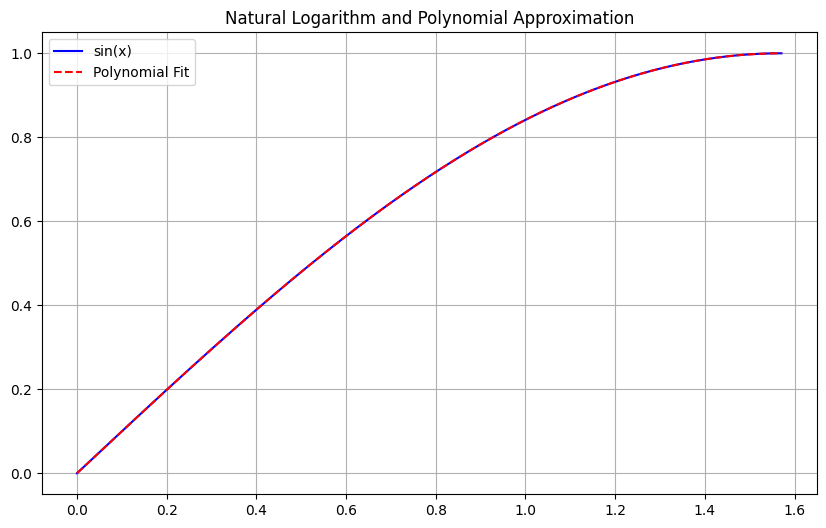

In [30]:
y_fit = np.polyval(coeficientes_mpmath_lst, x_poly_mp)
plt.figure(figsize=(10, 6))
plt.plot(x_poly_mp, y_target_mp, 'b-', label='sin(x)')
plt.plot(x_poly_mp, y_fit, 'r--', label='Polynomial Fit')
plt.legend()
plt.grid(True)
plt.title('Natural Logarithm and Polynomial Approximation')
plt.show()

In [31]:
# 1. Definir a precisão desejada para os cálculos com mpmath
# (dps = decimal places of precision; mpmath recomenda dps > precisão final desejada)
# Para 28 dígitos finais, usar pelo menos dps=40 ou 50.
mpmath.mp.dps = 50 # Aumente se necessário para ter mais margem

# 2. Definir o intervalo de aproximação para o polinômio.
# A função C# usa ln(s) = -ln(1/s) onde s está em [1, 2).
# Então, 1/s (vamos chamar de x_poly) está em (0.5, 1].
# É melhor aproximar ln(x_poly) neste intervalo (0.5, 1].
n_pontos = 10000  # Número de pontos para o ajuste.
                # Para um grau N, você precisa de pelo menos N+1 pontos.
                # Mais pontos podem levar a um melhor ajuste de mínimos quadrados.

# Constante LN2 com alta precisão usando mpmath

# Intervalo para r (o argumento do polinômio para exp(r))
# r está em [-LN2/2, LN2/2]
r_min_mp = 0
r_max_mp = mpmath.pi / 2  # Aproximando exp(r) para r em [0, pi/2]

x_poly_mp = mpmath.linspace(r_min_mp, r_max_mp, n_pontos)

# 3. Calcular os valores de y = ln(x_poly) usando mpmath
y_target_mp = [mpmath.cos(x) for x in x_poly_mp]

# 4. Grau do polinômio
grau = 20 # Comece com um grau como 15-20. Ajuste conforme necessário.
          # Um grau muito alto pode levar a instabilidade numérica.

print(f"Tentando ajustar um polinômio de grau {grau} com {n_pontos} pontos usando mpmath...")
print(f"Precisão de trabalho (mpmath.mp.dps): {mpmath.mp.dps}")

try:
    # Implementação de mínimos quadrados com mpmath
    # Queremos encontrar coeficientes c_0, c_1, ..., c_grau tal que
    # P(x) = c_0 * x^grau + c_1 * x^(grau-1) + ... + c_grau aproxime y_target_mp.
    # Isso é resolver o sistema linear V * c = Y no sentido de mínimos quadrados.
    # A solução é c = (V^T V)^(-1) V^T Y.

    # Construir a matriz de Vandermonde V com mpmath
    # V[i, j] = x_poly_mp[i] ^ (grau - j)
    V_mp = mpmath.matrix(n_pontos, grau + 1)
    for i in range(n_pontos):
        for j in range(grau + 1):
            # O polinômio é c[0]*x^grau + c[1]*x^(grau-1) + ... + c[grau]
            V_mp[i, j] = mpmath.power(x_poly_mp[i], grau - j)

    # Converter y_target_mp para uma matriz coluna mpmath
    Y_mp_col = mpmath.matrix(y_target_mp)

    # Calcular V^T
    V_T_mp = transpose_mpmath_matrix(V_mp)

    # Calcular (V^T V)
    V_T_V_mp = V_T_mp * V_mp

    # Calcular (V^T Y)
    V_T_Y_mp = V_T_mp * Y_mp_col
    
    # Resolver o sistema (V^T V) * coef = (V^T Y) para coef
    coeficientes_mpmath_lst = mpmath.lu_solve(V_T_V_mp, V_T_Y_mp)

    # coeficientes_mpmath_lst é uma matriz coluna, converter para lista de strings
    # Usar mpmath.nstr para formatar com alta precisão, evitando notação científica se possível
    # para facilitar a cópia para C#. O número de dígitos em nstr deve ser alto.
    coeficientes_mpmath_str = [mpmath.nstr(c, mpmath.mp.dps - 5, min_fixed=-100, max_fixed=100) for c in coeficientes_mpmath_lst]

    print("\nCoeficientes calculados com mpmath (alta precisão):")
    print(f"// Grau do polinômio: {grau}")
    print(f"// Intervalo de aproximação para x_poly: ({r_min_mp}, {r_max_mp}]")
    print(f"// Função aproximada: cos(x_poly)")
    print(f"// Precisão de trabalho mpmath (dps): {mpmath.mp.dps}")
    print(f"// Número de pontos de ajuste: {n_pontos}")
    print("private static readonly decimal[] CosCoefficients = new decimal[]")
    print("{")
    for i, c_str in enumerate(coeficientes_mpmath_str):
        formatted_c_str = c_str.strip()
        print(f"    {formatted_c_str}m{(',' if i < len(coeficientes_mpmath_str) - 1 else '')}")
    print("};")

    # Verificação opcional do erro máximo nos pontos de ajuste
    max_abs_error_check = mpmath.mpf(0)
    for i in range(n_pontos):
       x_val = x_poly_mp[i]
       y_actual_val = y_target_mp[i]
       poly_eval = mpmath.mpf(0)
       # Avaliar P(x) = c_0 * x^grau + c_1 * x^(grau-1) + ... + c_grau
       for j in range(grau + 1):
           poly_eval += coeficientes_mpmath_lst[j] * mpmath.power(x_val, grau - j)
       abs_error = mpmath.fabs(y_actual_val - poly_eval)
       if abs_error > max_abs_error_check:
           max_abs_error_check = abs_error
    print(f"\n// Verificação: Máximo erro absoluto da aproximação mpmath nos pontos de ajuste: {mpmath.nstr(max_abs_error_check, 10)}")
    # Um erro esperado para 28 dígitos de precisão seria algo na ordem de 10^-29 ou menor.
    # O erro nos pontos de ajuste não garante o erro máximo em todo o intervalo.
    if max_abs_error_check > mpmath.power(10, -30): # Ajuste este limiar conforme necessário
        print("// AVISO: O erro máximo nos pontos de ajuste pode ser maior do que o ideal para 28-29 dígitos de precisão.")

except Exception as e:
    print(f"\nErro ao calcular coeficientes com mpmath: {e}")
    print("Isso pode ocorrer se a matriz (V^T V) for mal condicionada ou singular.")
    print("Tente as seguintes sugestões:")
    print("  - Reduzir o 'grau' do polinômio (valores altos são propensos à instabilidade).")
    print("  - Aumentar 'n_pontos' (por exemplo, 2 * grau ou mais, até algumas centenas).")
    print("  - Aumentar 'mpmath.mp.dps' ainda mais (ex: 60 ou 70), pois os cálculos de V^T V podem perder precisão.")
    print("  - Certifique-se de que o intervalo de 'x_poly_mp' é razoável e não inclui pontos problemáticos.")

print("\n--- Notas Importantes ---")
print("1. Precisão dos Coeficientes: Os coeficientes gerados com `mpmath` devem ter alta precisão.")
print("   Copie-os para sua classe `DecimalMath` em C#.")
print("2. Teste Rigoroso em C#: Após atualizar os coeficientes, teste exaustivamente a função `Ln`")
print("   em C# contra valores de referência de alta precisão (ex: `mpmath.log` com `dps` alto).")
print("   A tolerância nos seus testes unitários C# (`DecimalMathTests.cs`) deve ser muito pequena (ex: 1e-28m).")
print("3. Estabilidade: Se encontrar problemas de instabilidade (erros grandes, falha na solução),")
print("   a principal estratégia é reduzir o grau do polinômio. Um polinômio de grau menor com")
print("   coeficientes muito precisos geralmente é melhor e mais estável.")
print("4. Convergência: Verifique o `Máximo erro absoluto` impresso. Se for muito maior que ~10^-29,")
print("   a aproximação pode não ser boa o suficiente para 28 dígitos em todo o intervalo.")

Tentando ajustar um polinômio de grau 20 com 10000 pontos usando mpmath...
Precisão de trabalho (mpmath.mp.dps): 50

Coeficientes calculados com mpmath (alta precisão):
// Grau do polinômio: 20
// Intervalo de aproximação para x_poly: (0, 1.5707963267948966192313216916397514420985846996876]
// Função aproximada: cos(x_poly)
// Precisão de trabalho mpmath (dps): 50
// Número de pontos de ajuste: 10000
private static readonly decimal[] CosCoefficients = new decimal[]
{
    0.000000000000000000288565372964675876144757721059369296791409032m,
    0.00000000000000000123651282535632288308409647339533272800706901m,
    -0.000000000000000162713757206367805794589848571568524226496727m,
    0.0000000000000000225663802737054005185905230900166258873027645m,
    0.0000000000000477388496870792266858161359855504940316057927m,
    0.000000000000000103844166481127080506763727299180822094809675m,
    -0.0000000000114708938721217246038198392343435334822920342m,
    0.00000000000000016525472901651917524545

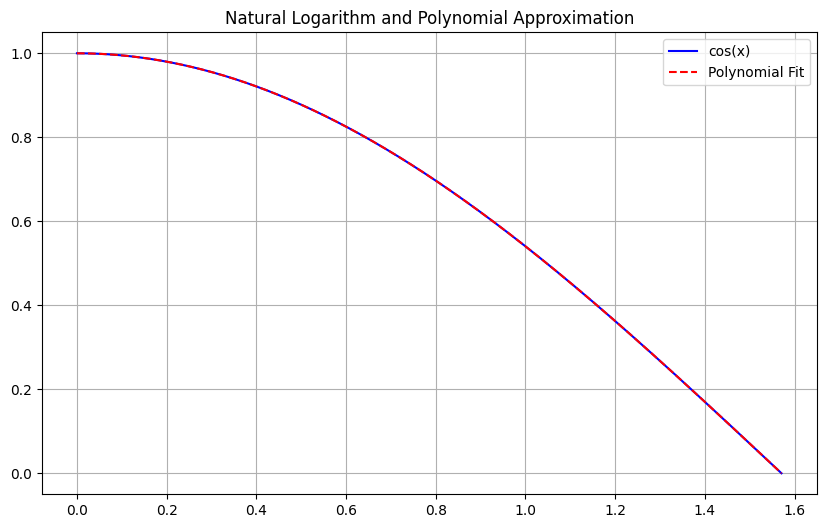

In [33]:
y_fit = np.polyval(coeficientes_mpmath_lst, x_poly_mp)
plt.figure(figsize=(10, 6))
plt.plot(x_poly_mp, y_target_mp, 'b-', label='cos(x)')
plt.plot(x_poly_mp, y_fit, 'r--', label='Polynomial Fit')
plt.legend()
plt.grid(True)
plt.title('Natural Logarithm and Polynomial Approximation')
plt.show()

In [46]:
# 1. Definir a precisão desejada para os cálculos com mpmath
# (dps = decimal places of precision; mpmath recomenda dps > precisão final desejada)
# Para 28 dígitos finais, usar pelo menos dps=40 ou 50.
mpmath.mp.dps = 50 # Aumente se necessário para ter mais margem

# 2. Definir o intervalo de aproximação para o polinômio.
# A função C# usa ln(s) = -ln(1/s) onde s está em [1, 2).
# Então, 1/s (vamos chamar de x_poly) está em (0.5, 1].
# É melhor aproximar ln(x_poly) neste intervalo (0.5, 1].
n_pontos = 1000  # Número de pontos para o ajuste.
                # Para um grau N, você precisa de pelo menos N+1 pontos.
                # Mais pontos podem levar a um melhor ajuste de mínimos quadrados.

# Constante LN2 com alta precisão usando mpmath

# Intervalo para r (o argumento do polinômio para exp(r))
# r está em [-LN2/2, LN2/2]
r_min_mp = -1
r_max_mp = 1

x_poly_mp = mpmath.linspace(r_min_mp, r_max_mp, n_pontos)

# 3. Calcular os valores de y = ln(x_poly) usando mpmath
y_target_mp = [mpmath.atan(x) for x in x_poly_mp]

# 4. Grau do polinômio
grau = 50 # Comece com um grau como 15-20. Ajuste conforme necessário.
          # Um grau muito alto pode levar a instabilidade numérica.

print(f"Tentando ajustar um polinômio de grau {grau} com {n_pontos} pontos usando mpmath...")
print(f"Precisão de trabalho (mpmath.mp.dps): {mpmath.mp.dps}")

try:
    # Implementação de mínimos quadrados com mpmath
    # Queremos encontrar coeficientes c_0, c_1, ..., c_grau tal que
    # P(x) = c_0 * x^grau + c_1 * x^(grau-1) + ... + c_grau aproxime y_target_mp.
    # Isso é resolver o sistema linear V * c = Y no sentido de mínimos quadrados.
    # A solução é c = (V^T V)^(-1) V^T Y.

    # Construir a matriz de Vandermonde V com mpmath
    # V[i, j] = x_poly_mp[i] ^ (grau - j)
    V_mp = mpmath.matrix(n_pontos, grau + 1)
    for i in range(n_pontos):
        for j in range(grau + 1):
            # O polinômio é c[0]*x^grau + c[1]*x^(grau-1) + ... + c[grau]
            V_mp[i, j] = mpmath.power(x_poly_mp[i], grau - j)

    # Converter y_target_mp para uma matriz coluna mpmath
    Y_mp_col = mpmath.matrix(y_target_mp)

    # Calcular V^T
    V_T_mp = transpose_mpmath_matrix(V_mp)

    # Calcular (V^T V)
    V_T_V_mp = V_T_mp * V_mp

    # Calcular (V^T Y)
    V_T_Y_mp = V_T_mp * Y_mp_col
    
    # Resolver o sistema (V^T V) * coef = (V^T Y) para coef
    coeficientes_mpmath_lst = mpmath.lu_solve(V_T_V_mp, V_T_Y_mp)

    # coeficientes_mpmath_lst é uma matriz coluna, converter para lista de strings
    # Usar mpmath.nstr para formatar com alta precisão, evitando notação científica se possível
    # para facilitar a cópia para C#. O número de dígitos em nstr deve ser alto.
    coeficientes_mpmath_str = [mpmath.nstr(c, mpmath.mp.dps - 5, min_fixed=-100, max_fixed=100) for c in coeficientes_mpmath_lst]

    print("\nCoeficientes calculados com mpmath (alta precisão):")
    print(f"// Grau do polinômio: {grau}")
    print(f"// Intervalo de aproximação para x_poly: ({r_min_mp}, {r_max_mp}]")
    print(f"// Função aproximada: atan(x_poly)")
    print(f"// Precisão de trabalho mpmath (dps): {mpmath.mp.dps}")
    print(f"// Número de pontos de ajuste: {n_pontos}")
    print("private static readonly decimal[] AtanCoefficients = new decimal[]")
    print("{")
    for i, c_str in enumerate(coeficientes_mpmath_str):
        formatted_c_str = c_str.strip()
        print(f"    {formatted_c_str}m{(',' if i < len(coeficientes_mpmath_str) - 1 else '')}")
    print("};")

    # Verificação opcional do erro máximo nos pontos de ajuste
    max_abs_error_check = mpmath.mpf(0)
    for i in range(n_pontos):
       x_val = x_poly_mp[i]
       y_actual_val = y_target_mp[i]
       poly_eval = mpmath.mpf(0)
       # Avaliar P(x) = c_0 * x^grau + c_1 * x^(grau-1) + ... + c_grau
       for j in range(grau + 1):
           poly_eval += coeficientes_mpmath_lst[j] * mpmath.power(x_val, grau - j)
       abs_error = mpmath.fabs(y_actual_val - poly_eval)
       if abs_error > max_abs_error_check:
           max_abs_error_check = abs_error
    print(f"\n// Verificação: Máximo erro absoluto da aproximação mpmath nos pontos de ajuste: {mpmath.nstr(max_abs_error_check, 10)}")
    # Um erro esperado para 28 dígitos de precisão seria algo na ordem de 10^-29 ou menor.
    # O erro nos pontos de ajuste não garante o erro máximo em todo o intervalo.
    if max_abs_error_check > mpmath.power(10, -30): # Ajuste este limiar conforme necessário
        print("// AVISO: O erro máximo nos pontos de ajuste pode ser maior do que o ideal para 28-29 dígitos de precisão.")

except Exception as e:
    print(f"\nErro ao calcular coeficientes com mpmath: {e}")
    print("Isso pode ocorrer se a matriz (V^T V) for mal condicionada ou singular.")
    print("Tente as seguintes sugestões:")
    print("  - Reduzir o 'grau' do polinômio (valores altos são propensos à instabilidade).")
    print("  - Aumentar 'n_pontos' (por exemplo, 2 * grau ou mais, até algumas centenas).")
    print("  - Aumentar 'mpmath.mp.dps' ainda mais (ex: 60 ou 70), pois os cálculos de V^T V podem perder precisão.")
    print("  - Certifique-se de que o intervalo de 'x_poly_mp' é razoável e não inclui pontos problemáticos.")

print("\n--- Notas Importantes ---")
print("1. Precisão dos Coeficientes: Os coeficientes gerados com `mpmath` devem ter alta precisão.")
print("   Copie-os para sua classe `DecimalMath` em C#.")
print("2. Teste Rigoroso em C#: Após atualizar os coeficientes, teste exaustivamente a função `Ln`")
print("   em C# contra valores de referência de alta precisão (ex: `mpmath.log` com `dps` alto).")
print("   A tolerância nos seus testes unitários C# (`DecimalMathTests.cs`) deve ser muito pequena (ex: 1e-28m).")
print("3. Estabilidade: Se encontrar problemas de instabilidade (erros grandes, falha na solução),")
print("   a principal estratégia é reduzir o grau do polinômio. Um polinômio de grau menor com")
print("   coeficientes muito precisos geralmente é melhor e mais estável.")
print("4. Convergência: Verifique o `Máximo erro absoluto` impresso. Se for muito maior que ~10^-29,")
print("   a aproximação pode não ser boa o suficiente para 28 dígitos em todo o intervalo.")

Tentando ajustar um polinômio de grau 50 com 1000 pontos usando mpmath...
Precisão de trabalho (mpmath.mp.dps): 50

Coeficientes calculados com mpmath (alta precisão):
// Grau do polinômio: 50
// Intervalo de aproximação para x_poly: (-1, 1]
// Função aproximada: atan(x_poly)
// Precisão de trabalho mpmath (dps): 50
// Número de pontos de ajuste: 1000
private static readonly decimal[] AtanCoefficients = new decimal[]
{
    0.00000000000000000000000000000000000000279200314605869457892687013666844461248517461m,
    0.00000215837246792548624087760883520679809007589564m,
    -0.0000000000000000000000000000000000000359487427885637843853966175761383985710707595m,
    -0.0000294774782675705031126099698051642857700982671m,
    0.000000000000000000000000000000000000217137168782255541607074705064568127919229946m,
    0.000192382592373848527249458319908413691295793657m,
    -0.000000000000000000000000000000000000817647677591548855259648724979532542667220046m,
    -0.000801176125756819730317691394

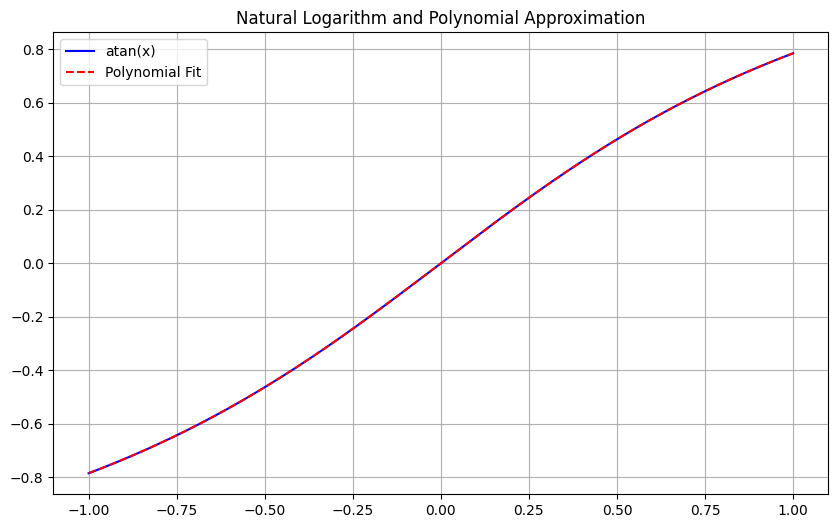

In [41]:
y_fit = np.polyval(coeficientes_mpmath_lst, x_poly_mp)
plt.figure(figsize=(10, 6))
plt.plot(x_poly_mp, y_target_mp, 'b-', label='atan(x)')
plt.plot(x_poly_mp, y_fit, 'r--', label='Polynomial Fit')
plt.legend()
plt.grid(True)
plt.title('Natural Logarithm and Polynomial Approximation')
plt.show()